# BOOTSTRAP  

---
## Import modules

In [12]:
import numpy as np # linear algebra
import pandas as pd  # data management (dataframes)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # plotting

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_text
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression 

from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

from sklearn.inspection import permutation_importance

from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor

# others
from mltools import model_tools as MT

### Prepare and Explore the Data

In [3]:
# Load file with the dataset
df = pd.read_csv('data/dataset_final.csv', sep = ",")
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,FECHA,UTIL,IRRAD,ANNO,DIA,DIASEM,MES,TRAMO
0,2015-01-01 00:00:00,0.000003,0.0,2015,1,3,1,0
1,2015-01-01 03:00:00,0.000006,0.0,2015,1,3,1,3
2,2015-01-01 06:00:00,0.067728,0.0,2015,1,3,1,6
3,2015-01-01 09:00:00,0.611120,760335.4,2015,1,3,1,9
4,2015-01-01 12:00:00,0.660956,1565422.5,2015,1,3,1,12


We do a short recap of the data and the features we have in the dataset. This would be complementary to the EDA done in the previous notebook.
<!-- Esto es complemento de lo que ya teniamos en el anterior notebook osea que se puede quitar-->

In [4]:
# Basic exploratory analysis
print('\nInfo variables:')
print(df.describe())


Info variables:
               UTIL         IRRAD          ANNO           DIA        DIASEM  \
count  17536.000000  1.753600e+04  17536.000000  17536.000000  17536.000000   
mean       0.191807  6.249594e+05   2017.500456     15.732664      3.000000   
std        0.243801  8.733386e+05      1.708230      8.801621      1.999601   
min       -0.000183  0.000000e+00   2015.000000      1.000000      0.000000   
25%        0.000025  0.000000e+00   2016.000000      8.000000      1.000000   
50%        0.031350  0.000000e+00   2017.500000     16.000000      3.000000   
75%        0.354966  1.229791e+06   2019.000000     23.000000      5.000000   
max        0.830403  3.042620e+06   2020.000000     31.000000      6.000000   

                MES        TRAMO  
count  17536.000000  17536.00000  
mean       6.521898     10.50000  
std        3.449085      6.87406  
min        1.000000      0.00000  
25%        4.000000      5.25000  
50%        7.000000     10.50000  
75%       10.000000     15

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17536 entries, 0 to 17535
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FECHA   17536 non-null  object 
 1   UTIL    17536 non-null  float64
 2   IRRAD   17536 non-null  float64
 3   ANNO    17536 non-null  int64  
 4   DIA     17536 non-null  int64  
 5   DIASEM  17536 non-null  int64  
 6   MES     17536 non-null  int64  
 7   TRAMO   17536 non-null  int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 1.1+ MB


In [6]:
df[['ANNO', 'DIA', 'DIASEM', 'MES', 'TRAMO']] = df[['ANNO', 'DIA', 'DIASEM', 'MES', 'TRAMO']].astype('category')

Finally, in order to build the models, we split the data into training and testing sets. We will use the training set to train the model and the testing set to evaluate the model.

In [9]:
# Define input and output matrices
INPUTS = ['FECHA','IRRAD','ANNO', 'DIA', 'DIASEM', 'MES', 'TRAMO']
OUTPUT = 'UTIL'
X = df[INPUTS]
y = df[OUTPUT]

# Normalmente en series temporales tendriamos que hacer una division secuencial
# sin embargo, como aqui tenemos variables que categorizan el dia, mes y año no es necesario
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,  #percentage of test data
                                                    random_state=0) #seed for replication

---
## 1. The bootstrap approach

Bootstrap is commonly used to quantify the uncertainty associated with a given estimator or statistical learning method. The bootstrap can be applied to many problems and methods, and is commonly used to estimate the standard errors of the coefficients estimated from model fits, or the distribution of error metrics, for example.

One of the great advantages of the bootstrap approach is that it can be applied in almost all situations. No complicated mathematical calculations
are required. Performing a bootstrap analysis entails only two steps: 

- First, decide which are the statistics of interest.
- Second, create a function that computes the statistic of interest (boot_function).
- Third, perform the bootstrap by repeatedly sampling observations from the data set with replacement.
- Fourth, analyse the bootstrap results to estimate the variability.

#### 3.1 Create the simulated data

In [10]:
# set the ramdom seed for reproductivility
np.random.seed(99999)

In [22]:
# Prepare the dataframe for easy 
data = {'x': x, 'y': y}
df = pd.DataFrame(data)
df

,x,y
0,0.000000,3.872282
1,0.010101,5.875394
2,0.020202,-2.877801
3,0.030303,3.675365
4,0.040404,1.539278
...,...,...
95,0.959596,10.064511
96,0.969697,1.710121
97,0.979798,4.789165
98,0.989899,3.917434


c:\Users\isaan\anaconda3\envs\ML2\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


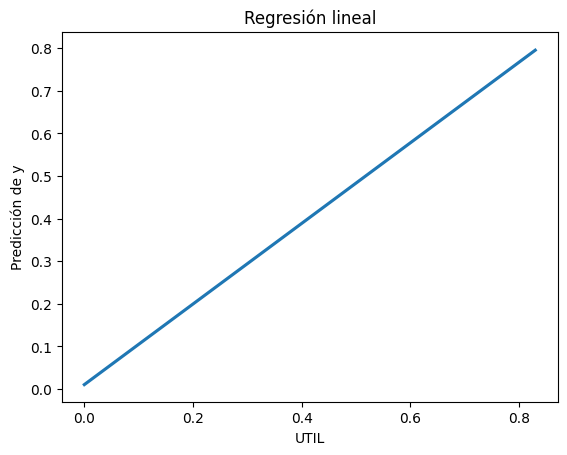

In [26]:
# Inicializa y ajusta el codificador one-hot
X_categorical = df[['ANNO', 'DIA', 'DIASEM', 'MES', 'TRAMO']]
one_hot_encoder = OneHotEncoder(drop='first', sparse=False)  # drop='first' evita la trampa de variables ficticias
X_categorical_encoded = one_hot_encoder.fit_transform(X_categorical)

# Concatena las características categóricas codificadas con las características numéricas continuas (si las hay)
X = np.concatenate((X_categorical_encoded, df[['IRRAD']].values), axis=1)

# Ajustar el modelo de regresión lineal utilizando todas las características (inputs)
lin_reg_sample = LinearRegression()
lin_reg_sample.fit(X, y)

# Obtener los coeficientes y el R-cuadrado del modelo
beta_0_sample = lin_reg_sample.intercept_
beta_1_sample = lin_reg_sample.coef_
r_squared_sample = lin_reg_sample.score(X, y)

# Crear un dataframe con las características (inputs) y la variable de salida (output) para usar en sns.regplot
data_for_plot = df.copy()
data_for_plot['y_pred'] = lin_reg_sample.predict(X)


# Plotear la línea de regresión resultante y un intervalo de confianza del 95%
sns.regplot(x=OUTPUT, y='y_pred', data=data_for_plot, scatter=False)
plt.title(f'Regresión lineal')
plt.xlabel(OUTPUT)
plt.ylabel('Predicción de y')
plt.show()

##### 2.4 Apply the bootstrap approach

In [24]:
# Create the function that computes the mean and variance
def boot_function_regress_line (df_bag):
    """
    Receives a dataframe with the bootstrapped resample (bag)
    Returns a new dataframe consisting of the values computed with the bag of data
    """
    # compute desired values from the particular bootstrapped sample
    X = df_bag[['x']]
    y = df_bag[['y']]

    # fit the simple regression line
    lin_reg = LinearRegression()  # Initializing estimator
    lin_reg.fit(X, y)  # Fitting linear regression model using the bag set

    # save in a dataframe for output
    d = dict(beta_0=lin_reg.intercept_[0], 
             beta_1=lin_reg.coef_.ravel()[0],
             r_squared = lin_reg.score(X, y))

    boot_stats = pd.DataFrame([d])
    
    return boot_stats


In [25]:
# check the function
st = boot_function_regress_line (df)
st

,beta_0,beta_1,r_squared
0,1.629607,6.194923,0.267996


In [26]:
# run bootstrap

# set the ramdom seed for reproductivility
np.random.seed(99999)

# Defining number of bootstrap (re)samples
n_boots = 5000

# Initializing DataFrame, to hold bootstrapped statistics
bootstrapped_stats = pd.DataFrame()

# In each iteration a bootstrap sample is formed
for i in range(n_boots):

    # sampling the original data in two sets: tr (train) and ts (test)
    train_set = resample(df,                # original dataframe for resampling
                         replace=True,      # sampling n_samples from data, with replacement
                         n_samples=len(df)) # the train_set sample has the same size than the original df
    
    # the test set consists of all observations not in train (usefull for computing OOB stats)
    test_set = df[~df.index.isin(train_set.index)]
    
    # compute bootstrapped stats using the training set
    bootstrapped_stats_i = boot_function_regress_line(train_set)
    bootstrapped_stats = pd.concat(objs=[bootstrapped_stats, bootstrapped_stats_i])

Main descriptive statistics:
            beta_0       beta_1    r_squared
count  5000.000000  5000.000000  5000.000000
mean      1.625684     6.199172     0.273494
std       0.576878     1.022100     0.071353
min      -0.591778     2.178435     0.037834
10%       0.880059     4.867745     0.181667
25%       1.231897     5.513223     0.225609
50%       1.638417     6.199572     0.272224
75%       2.014606     6.882724     0.320332
90%       2.370409     7.506089     0.365680
max       3.973572     9.824384     0.556130

Correlation matrix:
           beta_0  beta_1  r_squared
beta_0     1.0000 -0.8523    -0.6990
beta_1    -0.8523  1.0000     0.8835
r_squared -0.6990  0.8835     1.0000

Empirical distribution of the stats:


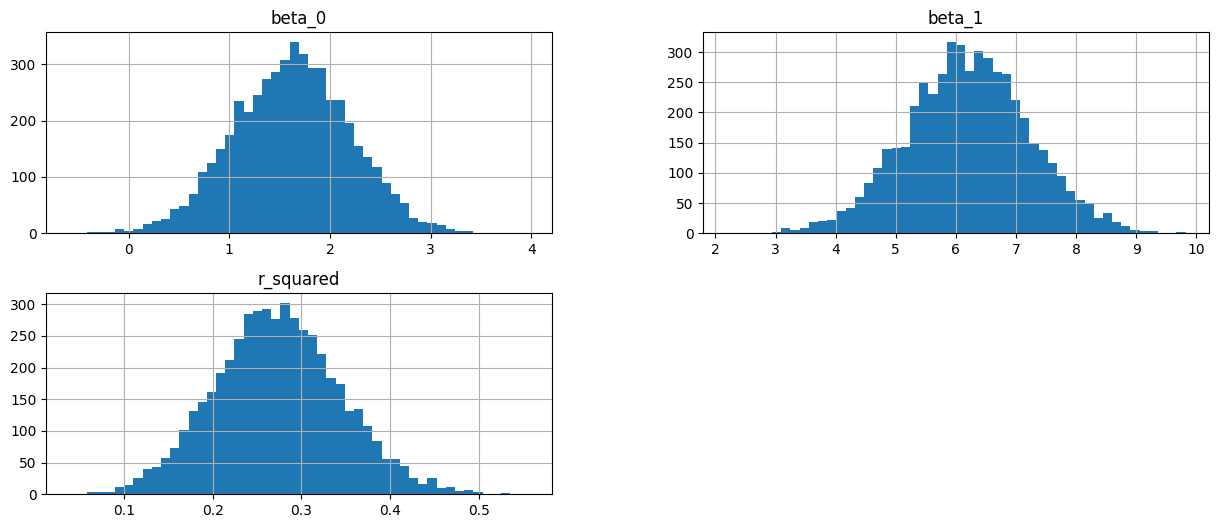

In [27]:
# Overview of the stats
print('Main descriptive statistics:')
print(bootstrapped_stats.describe(percentiles=[0.1,0.25,0.75,0.9]))

# correlation matrix
mat_corr = bootstrapped_stats.corr()
print('\nCorrelation matrix:')
print(np.round(mat_corr, 4))

# histograms
print('\nEmpirical distribution of the stats:')
bootstrapped_stats.hist(figsize=(15, 6), bins = 50, sharex = False)
plt.draw()

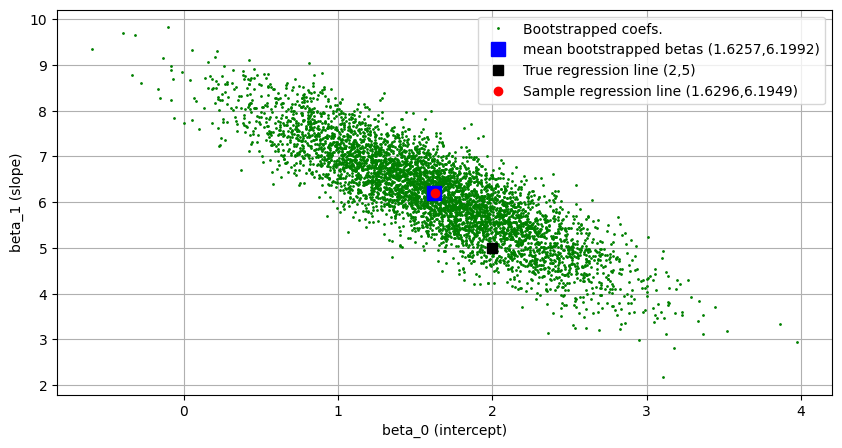

In [28]:
# Compare true line with estimated ones
mean_boots_beta_0 = np.mean(bootstrapped_stats.beta_0)
mean_boots_beta_1 =  np.mean(bootstrapped_stats.beta_1)

# Show all the statistics together
fig = plt.figure(1, figsize=(10, 5))
plt.plot(bootstrapped_stats.beta_0, bootstrapped_stats.beta_1, '.', color='g', markersize = 2, label = 'Bootstrapped coefs.')
plt.plot(mean_boots_beta_0, mean_boots_beta_1, 's', color='b', markersize = 10, label = f'mean bootstrapped betas ({np.round(mean_boots_beta_0,4)},{np.round(mean_boots_beta_1,4)})')
plt.plot(beta_0_true, beta_1_true, 's', color='k', markersize = 7, label = f'True regression line ({beta_0_true},{beta_1_true})')
plt.plot(beta_0_sample, beta_1_sample, 'o', color='r', markersize = 6, label = f'Sample regression line ({np.round(beta_0_sample,4)},{np.round(beta_1_sample,4)})')
plt.xlabel('beta_0 (intercept)')
plt.ylabel('beta_1 (slope)')
plt.legend()
plt.grid()
plt.show()

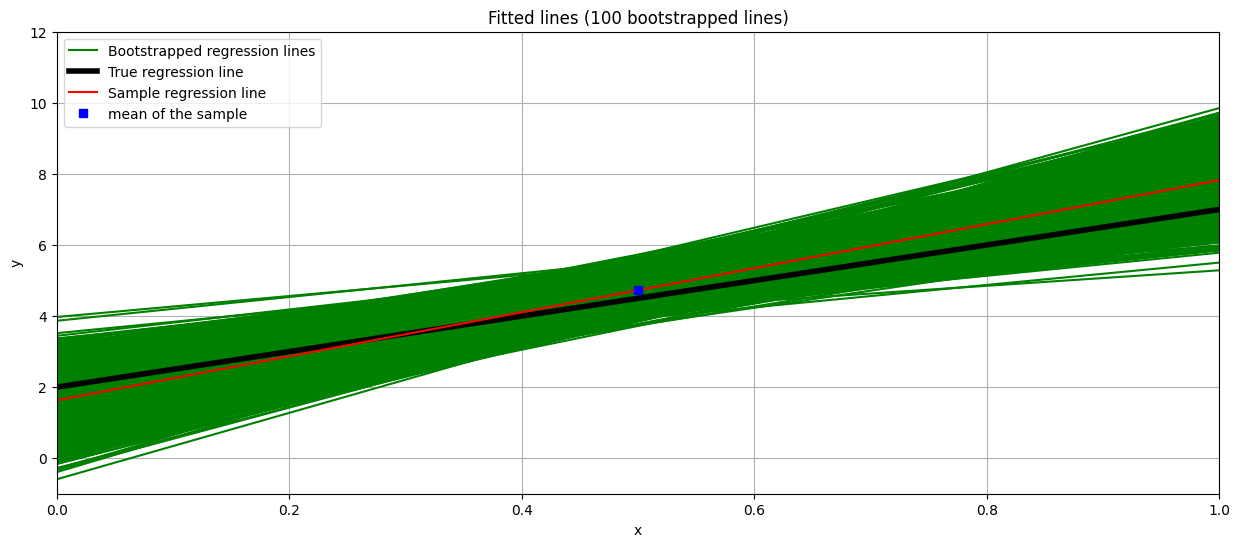

In [29]:
# show all the bootstrapped lines together for visual checking of the CONFIDENCE BAND provided by the bootstrap approach
fig = plt.figure(1, figsize=(15, 6))

plt.axline((0, bootstrapped_stats.iloc[0].beta_0), slope=bootstrapped_stats.iloc[0].beta_1, color = 'green', label ='Bootstrapped regression lines')
for i in range(1,n_boots):
    plt.axline((0, bootstrapped_stats.iloc[i].beta_0), slope=bootstrapped_stats.iloc[i].beta_1, color = 'green')

plt.plot(x,y_det_true,'-',color='black', linewidth = 4, label='True regression line')
plt.axline((0,beta_0_sample), slope=beta_1_sample, color = 'red', label = 'Sample regression line')
plt.plot(np.mean(df["x"]),np.mean(df["y"]), 's',color='blue', label = 'mean of the sample')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([0,1])
plt.ylim([-1,12])
plt.grid()
plt.legend()
plt.title(f'Fitted lines ({len(y)} bootstrapped lines)')
plt.show()